In [2]:
import numpy as np
#import pandas as pd
import polars as pl
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt

# Place field analysis
For now, two main questions are addressed: 
1. What is the average size of place fields? 
2. How likely is it that the contextual cells are just place cells with large place fields? 

I will try and run a Bayesian model comparison/estimation.

In [2]:
lf = pl.scan_csv("..\\results\\placefields.csv")

# Map recording_id -> 0..R-1
rec_map = (
    lf.select("recording_id")
      .unique()
      .sort("recording_id")
      .with_row_index("rec_idx")  # 0-based codes
)

# Join lazily, only collect at the end
df = (
    lf.join(rec_map, on="recording_id")
      .with_columns(
          pl.col("putative_contextual").cast(pl.Int8).alias("contextual"),
          pl.col("fwhm").cast(pl.Float64).alias("size"),    
      )
      .select("rec_idx", "neuron_id", "size", "contextual")
      .collect()
      
)

# to NumPy for PyMC
y          = df["size"].to_numpy()
rec_idx    = df["rec_idx"].to_numpy().astype(np.int64)
contextual = df["contextual"].to_numpy().astype(np.int8)
R = int(df["rec_idx"].max()) + 1
N = y.shape[0]

Based on the empirical data, what is the average size of a place field in my recordings? 
The animal navigates through a 150 - 200 cm long 1D corridor. 

shape: (1, 1)
┌───────────┐
│ size      │
│ ---       │
│ f64       │
╞═══════════╡
│ 16.732545 │
└───────────┘
shape: (1, 1)
┌──────────┐
│ size     │
│ ---      │
│ f64      │
╞══════════╡
│ 5.266058 │
└──────────┘


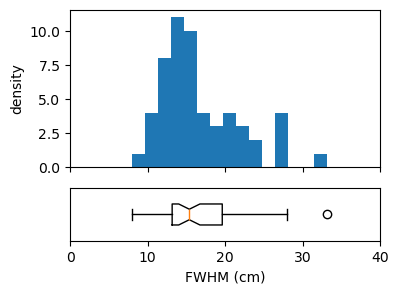

In [7]:

# Create figure 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4,3), height_ratios=[3,1])

ax1.hist(df.filter(pl.col("contextual")==0).select("size"), bins=15)
ax1.set_ylabel("density")
ax1.set_xticklabels([])
ax1.set_xlim(0,40)

ax2.boxplot(df.filter(pl.col("contextual")==0).select("size"),
            orientation="horizontal",
            notch=True,
            widths=0.4)
ax2.set_yticks([])
ax2.set_xlabel("FWHM (cm)")
ax2.set_xlim(0,40)

plt.savefig("../results/PF_distribution.svg")

print(df.filter(pl.col("contextual")==0).select("size").mean())
print(df.filter(pl.col("contextual")==0).select("size").std())



We now load the data and log-transform the place field size. This conforms to the following logic:

1. the log map $x$ &rarr; $log(x)$ takes ($0, \inf$) &rarr;  $\mathbb{R}$ and shrinks down the right tail of the distribution, which makes individual, extreme observations less dominating.
2. Multiplicative effects become additive in log-space, creating clear hierarchies for modeling.
3. I see a skew towards right-shifted values, that could be modeled with a log-normal distribution: after log-transformation, we can simply work with normals.

c:\Users\anneluka\.conda\envs\bayes-pymc\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu0_std, tau_std, sigma_std, z_r]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 92 seconds.
Sampling: [y_std_obs_gauss]


Output()


=== Model A (single) key params ===
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu0    3.242  0.167   2.927    3.545      0.004    0.004    2040.0    3040.0   
tau    0.459  0.128   0.237    0.699      0.003    0.002    1876.0    3263.0   
sigma  0.580  0.051   0.488    0.676      0.001    0.001    5715.0    5644.0   

       r_hat  
mu0      1.0  
tau      1.0  
sigma    1.0  


c:\Users\anneluka\.conda\envs\bayes-pymc\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu0_std, tau_std, sigma_std, z_r, nu_minus2]


Output()

Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 77 seconds.
Sampling: [y_std_obs]


Output()

             mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu0         3.221   0.170   2.896    3.534      0.003    0.002    3241.0   
tau         0.463   0.127   0.238    0.699      0.002    0.001    4363.0   
sigma       0.529   0.066   0.405    0.657      0.001    0.001    4648.0   
nu_minus2  16.501  15.267   0.004   44.139      0.166    0.210    4893.0   

           ess_tail  r_hat  
mu0          4746.0    1.0  
tau          6330.0    1.0  
sigma        3237.0    1.0  
nu_minus2    3636.0    1.0  


c:\Users\anneluka\.conda\envs\bayes-pymc\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_center_std, delta_std, tau_std, z_r, sigma1_std, sigma2_std, w2]


Output()

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 166 seconds.
Sampling: [y_std_mix]


Output()

c:\Users\anneluka\.conda\envs\bayes-pymc\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu1     2.789  0.110   2.587    2.999      0.002    0.002    4090.0    5458.0   
mu2     3.817  0.212   3.432    4.207      0.004    0.002    3575.0    6290.0   
sigma1  0.199  0.038   0.130    0.270      0.000    0.000    6339.0    8695.0   
sigma2  0.542  0.115   0.334    0.753      0.002    0.001    5067.0    8257.0   
w2      0.401  0.089   0.243    0.572      0.001    0.001    5325.0    7542.0   

        r_hat  
mu1       1.0  
mu2       1.0  
sigma1    1.0  
sigma2    1.0  
w2        1.0  


c:\Users\anneluka\.conda\envs\bayes-pymc\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_center_std, delta_std, tau_std, z_r, sigma1_std, sigma2_std, nu, w2]


Output()

Sampling 4 chains for 5_000 tune and 4_000 draw iterations (20_000 + 16_000 draws total) took 221 seconds.
Sampling: [y_std_mix]


Output()

          mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu1      2.803   0.114   2.594    3.023      0.002    0.002    3858.0   
mu2      3.856   0.213   3.451    4.235      0.003    0.002    4200.0   
sigma1   0.195   0.042   0.129    0.270      0.001    0.004    6448.0   
sigma2   0.504   0.119   0.293    0.729      0.002    0.001    5542.0   
w2       0.384   0.088   0.228    0.553      0.001    0.001    5675.0   
nu      14.525  11.178   0.286   35.038      0.096    0.120    9898.0   

        ess_tail  r_hat  
mu1       3808.0    1.0  
mu2       5783.0    1.0  
sigma1    8068.0    1.0  
sigma2    7007.0    1.0  
w2        6510.0    1.0  
nu        6575.0    1.0  


c:\Users\anneluka\.conda\envs\bayes-pymc\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



=== LOO comparison (higher elpd_loo is better) ===
          rank   elpd_loo      p_loo  elpd_diff    weight        se       dse  \
mix2         0 -87.875368  15.527727   0.000000  0.622478  7.040805  0.000000   
mix2t        1 -88.447204  15.770445   0.571836  0.346394  6.984475  0.675845   
gaussian     2 -97.285675   9.898141   9.410308  0.025012  6.114294  5.363080   
single_t     3 -98.817137  12.375385  10.941770  0.006116  6.625650  5.350857   

          warning scale  
mix2         True   log  
mix2t       False   log  
gaussian    False   log  
single_t    False   log  


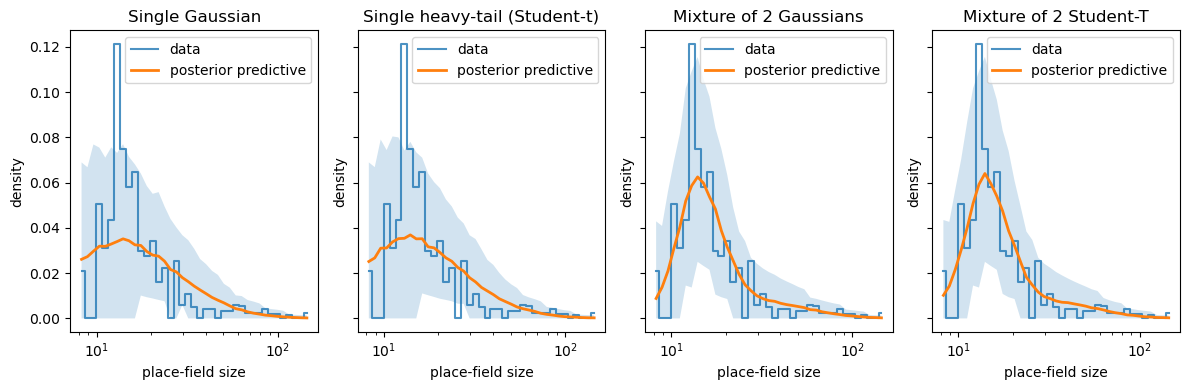

In [24]:
# ---------- config ----------
PATH = r"..\results\placefields.csv"   
SEPARATOR = ","                        
SIZE_COL = "fwhm"                      
# ----------------------------

import polars as pl
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import arviz as az

# ----------------------------
# 1) Load with Polars (eager)
# ----------------------------
df_main = pl.read_csv(PATH, separator=SEPARATOR)
# sanity: make sure expected columns exist 
needed = {"recording_id", "neuron_id", SIZE_COL, "putative_contextual"}
missing = needed - set(df_main.columns)
if missing:
    raise ValueError(f"Missing columns: {missing}. Have: {df_main.columns}")

# map recording_id -> 0..R-1 (stable)
rec_map = (
    df_main.select("recording_id")
           .unique()
           .sort("recording_id")
           .with_row_index(name="rec_idx")
)

df = (
    df_main.join(rec_map, on="recording_id")
           .with_columns(
               pl.col("putative_contextual").cast(pl.Int8).alias("contextual"),
               pl.col(SIZE_COL).cast(pl.Float64).alias("size"),
           )
           .select("rec_idx", "neuron_id", "size", "contextual")
)

# to NumPy for PyMC
y          = df["size"].to_numpy()
rec_idx    = df["rec_idx"].to_numpy().astype(np.int64)
contextual = df["contextual"].to_numpy().astype(np.int8)
R = int(df["rec_idx"].max()) + 1
N = y.shape[0]
# y: >0 sizes in original units; rec_idx: 0..R-1
y_pos = np.clip(y, 1e-6, None)
y_log = np.log(y_pos)
ybar, ysd = float(y_log.mean()), float(y_log.std(ddof=0))
y_std = (y_log - ybar) / ysd
N = y_std.size

# ----------------------------
# Model A: single component gaussian
#     (hierarchical LogNormal via Normal on log-scale)
#     non-centered, standardized
# ----------------------------
with pm.Model() as model_single:
    mu0_std   = pm.Normal("mu0_std", 0.0, 1.5)
    tau_std   = pm.HalfNormal("tau_std", 0.5)
    sigma_std = pm.HalfNormal("sigma_std", 0.5)

    z_r = pm.Normal("z_r", 0.0, 1.0, shape=R)
    mu_r_std = pm.Deterministic("mu_r_std", mu0_std + tau_std * z_r[rec_idx])

    y_std_obs_gauss = pm.Normal("y_std_obs_gauss", mu=mu_r_std, sigma=sigma_std, observed=y_std)

    # back-transform to log-scale parameters for interpretability
    mu0   = pm.Deterministic("mu0",   mu0_std * ysd + ybar)
    tau   = pm.Deterministic("tau",   tau_std * ysd)
    sigma = pm.Deterministic("sigma", sigma_std * ysd)

    idata_single_gauss = pm.sample(
        draws=2000, tune=2000, chains=4, random_seed=42,
        init="jitter+adapt_diag", target_accept=0.97,
        idata_kwargs={"log_likelihood": True}
    )
    ppc_single_gauss = pm.sample_posterior_predictive(idata_single_gauss)

loo_single_gauss = az.loo(idata_single_gauss, var_name="y_std_obs_gauss", pointwise=True)

print("\n=== Model A (single) key params ===")
print(az.summary(idata_single_gauss, var_names=["mu0","tau","sigma"]))

# ---------------------------------------
# Model S: single heavy-tail (Student-t)
# ---------------------------------------
with pm.Model() as model_single_t:
    # non-centered hierarchical location on standardized log-scale
    mu0_std   = pm.Normal("mu0_std", 0.0, 1.5)
    tau_std   = pm.HalfNormal("tau_std", 0.5)         # between-recording SD (std units)
    sigma_std = pm.HalfNormal("sigma_std", 0.5)       # within SD (std units)
    z_r = pm.Normal("z_r", 0.0, 1.0, shape=R)
    mu_r_std = pm.Deterministic("mu_r_std", mu0_std + tau_std * z_r[rec_idx])

    # heavy tail via Student-t (nu > 2 → finite variance)
    nu = pm.Exponential("nu_minus2", 1/15) + 2
    y_std_obs = pm.StudentT("y_std_obs", nu=nu, mu=mu_r_std, sigma=sigma_std, observed=y_std)

    # back-transform (log-scale params for interpretability)
    mu0   = pm.Deterministic("mu0",   mu0_std * ysd + ybar)
    tau   = pm.Deterministic("tau",   tau_std * ysd)
    sigma = pm.Deterministic("sigma", sigma_std * ysd)

    idata_single = pm.sample(draws=3000, tune=3000, chains=4, random_seed=41,
                             init="jitter+adapt_diag", target_accept=0.99,
                             idata_kwargs={"log_likelihood": True})
    ppc_single   = pm.sample_posterior_predictive(idata_single)
    loo_single   = az.loo(idata_single, var_name="y_std_obs", pointwise=True)

print(az.summary(idata_single, var_names=["mu0","tau","sigma","nu_minus2"]))

# ---------------------------------------------------------
# Model M: 2-Gaussian mixture (ordered means, shared shift)
# ---------------------------------------------------------
with pm.Model() as model_mix2:
    # ordered global means on standardized log-scale (identifiable)
    mu_center_std = pm.Normal("mu_center_std", 0.0, 1.5)
    delta_std     = pm.HalfNormal("delta_std", 0.7)
    mu1_std = pm.Deterministic("mu1_std", mu_center_std - 0.5 * delta_std)
    mu2_std = pm.Deterministic("mu2_std", mu_center_std + 0.5 * delta_std)

    # one recording random intercept shared by both components
    tau_std = pm.HalfNormal("tau_std", 0.5)
    z_r = pm.Normal("z_r", 0.0, 1.0, shape=R)
    a_r = tau_std * z_r[rec_idx]

    mu1_r_std = pm.Deterministic("mu1_r_std", mu1_std + a_r)
    mu2_r_std = pm.Deterministic("mu2_r_std", mu2_std + a_r)

    # component scales
    sigma1_std = pm.HalfNormal("sigma1_std", 0.5)
    sigma2_std = pm.HalfNormal("sigma2_std", 0.5)

    # global mixture weight (no covariates here)
    w2 = pm.Beta("w2", 1, 1)  # Prob(component 2). Weight vector is [1-w2, w2]
    w = pt.stack([1 - w2, w2])

    comp1 = pm.Normal.dist(mu=mu1_r_std, sigma=sigma1_std)
    comp2 = pm.Normal.dist(mu=mu2_r_std, sigma=sigma2_std)
    y_std_mix = pm.Mixture("y_std_mix", w=w, comp_dists=[comp1, comp2], observed=y_std)

    # back-transform to log-scale (medians on original scale = exp(mu*))
    mu1   = pm.Deterministic("mu1",   mu1_std * ysd + ybar)
    mu2   = pm.Deterministic("mu2",   mu2_std * ysd + ybar)
    tau   = pm.Deterministic("tau",   tau_std * ysd)
    sigma1 = pm.Deterministic("sigma1", sigma1_std * ysd)
    sigma2 = pm.Deterministic("sigma2", sigma2_std * ysd)

    idata_mix = pm.sample(draws=4000, tune=4000, chains=4, random_seed=43,
                          init="jitter+adapt_diag", target_accept=0.99,
                          nuts_kwargs=dict(max_treedepth=15),
                          idata_kwargs={"log_likelihood": True})
    ppc_mix   = pm.sample_posterior_predictive(idata_mix)
    loo_mix   = az.loo(idata_mix, var_name="y_std_mix", pointwise=True)

print(az.summary(idata_mix, var_names=["mu1","mu2","sigma1","sigma2","w2"]))


# ---------------------------------------------------------
# Model MT (robust): 2-Component **Student-t** mixture
#   - ordered means (identifiable)
#   - shared recording shift
#   - heavy tails via shared nu
# ---------------------------------------------------------
with pm.Model() as model_mix2_t:
    # ordered global means on standardized log-scale
    mu_center_std = pm.Normal("mu_center_std", 0.0, 1.5)
    delta_std     = pm.HalfNormal("delta_std", 0.7)
    mu1_std = pm.Deterministic("mu1_std", mu_center_std - 0.5 * delta_std)
    mu2_std = pm.Deterministic("mu2_std", mu_center_std + 0.5 * delta_std)

    # shared recording random intercept (non-centered)
    tau_std = pm.HalfNormal("tau_std", 0.5)
    z_r = pm.Normal("z_r", 0.0, 1.0, shape=R)
    a_r = tau_std * z_r[rec_idx]
    mu1_r_std = pm.Deterministic("mu1_r_std", mu1_std + a_r)
    mu2_r_std = pm.Deterministic("mu2_r_std", mu2_std + a_r)

    # component scales
    sigma1_std = pm.HalfNormal("sigma1_std", 0.5)
    sigma2_std = pm.HalfNormal("sigma2_std", 0.5)

    # heavy tails (shared df; >2 keeps variance finite)
    nu = pm.Exponential("nu", 1/10) + 2

    # global mixture weight (no covariates)
    w2 = pm.Beta("w2", 1, 1)
    w = pt.stack([1 - w2, w2])

    # two Student-t components on standardized log-scale
    comp1 = pm.StudentT.dist(nu=nu, mu=mu1_r_std, sigma=sigma1_std)
    comp2 = pm.StudentT.dist(nu=nu, mu=mu2_r_std, sigma=sigma2_std)

    y_std_mix = pm.Mixture("y_std_mix", w=w, comp_dists=[comp1, comp2], observed=y_std)

    # back-transform to log(original) units for interpretability
    mu1   = pm.Deterministic("mu1",   mu1_std * ysd + ybar)
    mu2   = pm.Deterministic("mu2",   mu2_std * ysd + ybar)
    tau   = pm.Deterministic("tau",   tau_std * ysd)
    sigma1 = pm.Deterministic("sigma1", sigma1_std * ysd)
    sigma2 = pm.Deterministic("sigma2", sigma2_std * ysd)

    idata_mix_t = pm.sample(
        draws=4000, tune=5000, chains=4, random_seed=43,
        init="jitter+adapt_diag", target_accept=0.99,
        nuts_kwargs=dict(max_treedepth=15),
        idata_kwargs={"log_likelihood": True}
    )
    ppc_mix_t = pm.sample_posterior_predictive(idata_mix_t)

loo_mix_t = az.loo(idata_mix_t, var_name="y_std_mix", pointwise=True)
print(az.summary(idata_mix_t, var_names=["mu1","mu2","sigma1","sigma2","w2","nu"]))
# ---------------------
# Compare & visualize
# ---------------------
cmp = az.compare({"gaussian": idata_single_gauss, "single_t": idata_single, "mix2": idata_mix, "mix2t": idata_mix_t}, ic="loo", method="BB-pseudo-BMA")
print("\n=== LOO comparison (higher elpd_loo is better) ===")
print(cmp)

# Posterior predictive overlay (overall), back to original units
import matplotlib.pyplot as plt

def back_ppc(ppc, var, ybar, ysd, max_draws=1000):
    arr = ppc.posterior_predictive[var].values  # (chain, draw, N)
    S = arr.shape[0] * arr.shape[1]
    if S > max_draws:
        rng = np.random.default_rng(0)
        # reshape then subsample draws
        arr = arr.reshape(S, arr.shape[-1])[rng.choice(S, max_draws, replace=False)]
    else:
        arr = arr.reshape(S, arr.shape[-1])
    return np.exp(ybar + ysd * arr)

bins = np.logspace(np.log10(y_pos.min()), np.log10(y_pos.max()), 40)

def plot_data_vs_ppc(ax, y_obs, y_ppc, bins, title):
    h, _ = np.histogram(y_obs, bins=bins, density=True)
    centers = 0.5*(bins[:-1] + bins[1:])
    ax.step(centers, h, where="mid", label="data", alpha=0.8)
    # compute PPC band
    H = np.array([np.histogram(s, bins=bins, density=True)[0] for s in y_ppc])
    ax.plot(centers, H.mean(0), lw=2, label="posterior predictive")
    ax.fill_between(centers, np.quantile(H, 0.05, 0), np.quantile(H, 0.95, 0), alpha=0.2)
    ax.set_xscale("log"); ax.set_xlabel("place-field size"); ax.set_ylabel("density"); ax.set_title(title); ax.legend()

ypcc_gaussian = back_ppc(ppc_single_gauss, "y_std_obs_gauss", ybar, ysd)
yppc_single = back_ppc(ppc_single, "y_std_obs", ybar, ysd)
yppc_mix    = back_ppc(ppc_mix,    "y_std_mix", ybar, ysd)
yppc_mix_t = back_ppc(ppc_mix_t, "y_std_mix", ybar, ysd)

fig, axes = plt.subplots(1, 4, figsize=(12,4), sharey=True)
plot_data_vs_ppc(axes[0], y_pos, ypcc_gaussian, bins, "Single Gaussian")
plot_data_vs_ppc(axes[1], y_pos, yppc_single, bins, "Single heavy-tail (Student-t)")
plot_data_vs_ppc(axes[2], y_pos, yppc_mix,    bins, "Mixture of 2 Gaussians")
plot_data_vs_ppc(axes[3], y_pos, yppc_mix_t, bins, "Mixture of 2 Student-T")
plt.tight_layout(); plt.show()

c:\Users\anneluka\.conda\envs\bayes-pymc\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\anneluka\.conda\envs\bayes-pymc\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


58 1.9185962633125402 shape: (1, 4)
┌─────────┬───────────┬───────┬────────────┐
│ rec_idx ┆ neuron_id ┆ size  ┆ contextual │
│ ---     ┆ ---       ┆ ---   ┆ ---        │
│ u32     ┆ str       ┆ f64   ┆ i8         │
╞═════════╪═══════════╪═══════╪════════════╡
│ 8       ┆ 4         ┆ 21.01 ┆ 0          │
└─────────┴───────────┴───────┴────────────┘


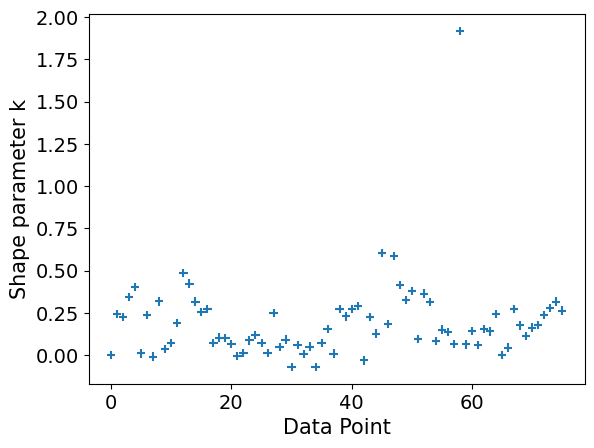

In [23]:
loo_mix = az.loo(idata_mix, var_name="y_std_mix", pointwise=True)
az.plot_khat(loo_mix);                # look for k-hat > 0.7 or > 1.0
# If a few points are bad:
# which index has the largest k?
loo_mix = az.loo(idata_mix, var_name="y_std_mix", pointwise=True)
k = loo_mix.pareto_k.values  # (N,)
i_bad = int(k.argmax())
print(i_bad, k[i_bad], df[i_bad])  # look at neuron_id, recording_id, size, contextual

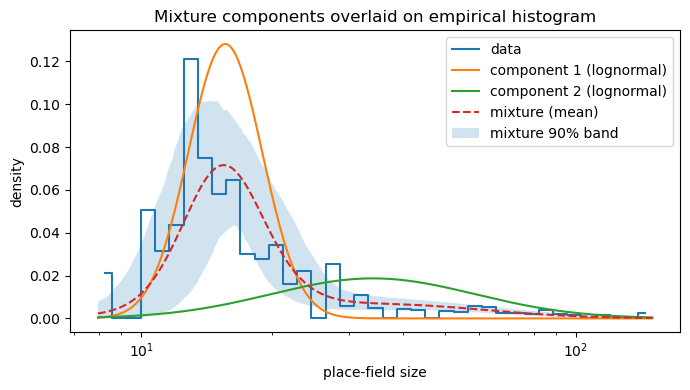

In [25]:
post = idata_mix.posterior

# Posterior draws of log-scale (original units) params and global weight
mu1_draw = post["mu1"].values.reshape(-1)      # log-median of comp1
mu2_draw = post["mu2"].values.reshape(-1)      # log-median of comp2
s1_draw  = post["sigma1"].values.reshape(-1)   # log-scale SD comp1
s2_draw  = post["sigma2"].values.reshape(-1)   # log-scale SD comp2
w2_draw  = post["w2"].values.reshape(-1)       # P(component 2)

# Grid on original scale (positive, right-skewed → log-spaced)
x = np.logspace(np.log10(y.min()), np.log10(y.max()), 400)

def lognorm_pdf(x, mu, sigma):
    return (1.0/(x * sigma * np.sqrt(2*np.pi))) * np.exp(-0.5*((np.log(x) - mu)/sigma)**2)

# "Representative" component curves via posterior medians
mu1_m, mu2_m = np.median(mu1_draw), np.median(mu2_draw)
s1_m, s2_m   = np.median(s1_draw),  np.median(s2_draw)
w2_m         = np.median(w2_draw)

f1_m = lognorm_pdf(x, mu1_m, s1_m)
f2_m = lognorm_pdf(x, mu2_m, s2_m)
mix_m = (1 - w2_m)*f1_m + w2_m*f2_m

# Credible band for the mixture density
rng = np.random.default_rng(0)
idx = rng.choice(len(mu1_draw), size=min(1000, len(mu1_draw)), replace=False)
F = []
for i in idx:
    f1 = lognorm_pdf(x, mu1_draw[i], s1_draw[i])
    f2 = lognorm_pdf(x, mu2_draw[i], s2_draw[i])
    F.append((1 - w2_draw[i]) * f1 + w2_draw[i] * f2)
F = np.asarray(F)
mix_lo, mix_hi = np.quantile(F, [0.05, 0.95], axis=0)
mix_mean = F.mean(axis=0)

# Empirical histogram (density) on the same x-grid
bins = np.logspace(np.log10(y.min()), np.log10(y.max()), 40)
h, _ = np.histogram(y, bins=bins, density=True)
centers = 0.5*(bins[:-1] + bins[1:])

# ----- Plot -----
fig, ax = plt.subplots(figsize=(7,4))
ax.set_xscale("log")
ax.step(centers, h, where="mid", label="data")
ax.plot(x, f1_m, label="component 1 (lognormal)")
ax.plot(x, f2_m, label="component 2 (lognormal)")
ax.plot(x, mix_mean, linestyle="--", label="mixture (mean)")
ax.fill_between(x, mix_lo, mix_hi, alpha=0.2, label="mixture 90% band")
ax.set_xlabel("place-field size")
ax.set_ylabel("density")
ax.set_title("Mixture components overlaid on empirical histogram")
ax.legend()
plt.tight_layout()
plt.show()

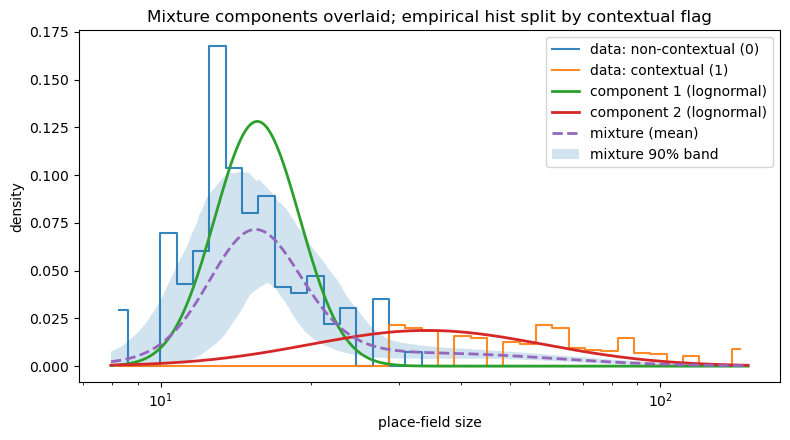

In [13]:
# --- grab posterior draws from the fitted 2-component mixture ---
post = idata_mix.posterior
mu1_draw = post["mu1"].values.reshape(-1)      # log-median comp1
mu2_draw = post["mu2"].values.reshape(-1)      # log-median comp2
s1_draw  = post["sigma1"].values.reshape(-1)   # log-scale SD comp1
s2_draw  = post["sigma2"].values.reshape(-1)   # log-scale SD comp2
w2_draw  = post["w2"].values.reshape(-1)       # global mixture weight (comp2)

# representative component curves via posterior medians
mu1_m, mu2_m = np.median(mu1_draw), np.median(mu2_draw)
s1_m,  s2_m  = np.median(s1_draw),  np.median(s2_draw)
w2_m         = np.median(w2_draw)

def lognorm_pdf(x, mu, sigma):
    return (1.0/(x * sigma * np.sqrt(2*np.pi))) * np.exp(-0.5*((np.log(x) - mu)/sigma)**2)

# x-grid on original scale
x = np.logspace(np.log10(y.min()), np.log10(y.max()), 400)

# component and mixture curves
f1_m  = lognorm_pdf(x, mu1_m, s1_m)
f2_m  = lognorm_pdf(x, mu2_m, s2_m)
mix_m = (1 - w2_m)*f1_m + w2_m*f2_m

# mixture credible band
rng = np.random.default_rng(0)
idx = rng.choice(len(mu1_draw), size=min(1000, len(mu1_draw)), replace=False)
F = []
for i in idx:
    f1 = lognorm_pdf(x, mu1_draw[i], s1_draw[i])
    f2 = lognorm_pdf(x, mu2_draw[i], s2_draw[i])
    F.append((1 - w2_draw[i]) * f1 + w2_draw[i] * f2)
F = np.asarray(F)
mix_lo, mix_hi = np.quantile(F, [0.05, 0.95], axis=0)
mix_mean = F.mean(axis=0)

# --- empirical histograms split by contextual flag ---
mask0 = (contextual == 0)
mask1 = (contextual == 1)

# shared log-spaced bins so the two histograms are comparable
bins = np.logspace(np.log10(y.min()), np.log10(y.max()), 40)

h0, _ = np.histogram(y[mask0], bins=bins, density=True)
h1, _ = np.histogram(y[mask1], bins=bins, density=True)
centers = 0.5*(bins[:-1] + bins[1:])

# --- plot ---
fig, ax = plt.subplots(figsize=(8,4.5))
ax.set_xscale("log")

# empirical data (two colors)
ax.step(centers, h0, where="mid", label="data: non-contextual (0)", alpha=0.9)
ax.step(centers, h1, where="mid", label="data: contextual (1)", alpha=0.9)

# components and mixture
ax.plot(x, f1_m, label="component 1 (lognormal)", linewidth=2)
ax.plot(x, f2_m, label="component 2 (lognormal)", linewidth=2)
ax.plot(x, mix_mean, linestyle="--", label="mixture (mean)", linewidth=2)
ax.fill_between(x, mix_lo, mix_hi, alpha=0.2, label="mixture 90% band")

ax.set_xlabel("place-field size")
ax.set_ylabel("density")
ax.set_title("Mixture components overlaid; empirical hist split by contextual flag")
ax.legend()
plt.tight_layout()
plt.show()

In [27]:
df_main = pl.read_csv(PATH, separator=SEPARATOR)

# sanity: make sure expected columns exist
needed = {"recording_id", "neuron_id", SIZE_COL, "putative_contextual"}
missing = needed - set(df_main.columns)
if missing:
    raise ValueError(f"Missing columns: {missing}. Have: {df_main.columns}")

# map recording_id -> 0..R-1 (stable)
rec_map = (
    df_main.select("recording_id")
           .unique()
           .sort("recording_id")
           .with_row_index(name="rec_idx")
)

# keep length in your Polars frame
df = (
    df_main.join(rec_map, on="recording_id")
           .with_columns(
               pl.col("putative_contextual").cast(pl.Int8).alias("contextual"),
               pl.col(SIZE_COL).cast(pl.Float64).alias("size"),
           )
           .select("rec_idx","recording_id","neuron_id","size","contextual","length_of_VR")
)

# numpy arrays
y          = df["size"].to_numpy()
rec_idx    = df["rec_idx"].to_numpy().astype(np.int64)
contextual = df["contextual"].to_numpy().astype(np.int8)
length     = df["length_of_VR"].to_numpy().astype(np.int64)   # values in {150, 200}
L200       = (length == 200).astype(np.int8)                   # 0/1 indicator

# standardize the outcome (log-size), as before
import numpy as np
y_pos = np.clip(y, 1e-6, None)
y_log = np.log(y_pos)
ybar, ysd = float(y_log.mean()), float(y_log.std(ddof=0))
y_std = (y_log - ybar)/ysd
R = int(df["rec_idx"].max()) + 1

In [28]:
with pm.Model() as model_mix_len:
    # ordered global means (identifiability) on the standardized log-scale
    mu_center_std = pm.Normal("mu_center_std", 0.0, 1.5)
    delta_std     = pm.HalfNormal("delta_std", 0.7)
    mu1_std = pm.Deterministic("mu1_std", mu_center_std - 0.5*delta_std)
    mu2_std = pm.Deterministic("mu2_std", mu_center_std + 0.5*delta_std)

    # recording random intercept shared by both components
    tau_std = pm.HalfNormal("tau_std", 0.5)
    z_r = pm.Normal("z_r", 0.0, 1.0, shape=R)
    a_r = tau_std * z_r[rec_idx]

    # length effect on *small* component mean (standardized log-scale)
    gamma1 = pm.Normal("gamma1", 0.0, 0.7)   # effect of L200 on comp-1 mean
    mu1_r_std = pm.Deterministic("mu1_r_std", mu1_std + a_r + gamma1 * L200)
    mu2_r_std = pm.Deterministic("mu2_r_std", mu2_std + a_r)

    # component scales
    sigma1_std = pm.HalfNormal("sigma1_std", 0.5)
    sigma2_std = pm.HalfNormal("sigma2_std", 0.5)

    # global mixture weight
    w2 = pm.Beta("w2", 1, 1)
    w = pt.stack([1 - w2, w2])

    comp1 = pm.Normal.dist(mu=mu1_r_std, sigma=sigma1_std)
    comp2 = pm.Normal.dist(mu=mu2_r_std, sigma=sigma2_std)
    y_std_mix = pm.Mixture("y_std_mix", w=w, comp_dists=[comp1, comp2], observed=y_std)

    # back-transform (log units) for interpretability
    mu1   = pm.Deterministic("mu1",   mu1_std * ysd + ybar)          # baseline small-comp median (log)
    mu2   = pm.Deterministic("mu2",   mu2_std * ysd + ybar)
    sigma1 = pm.Deterministic("sigma1", sigma1_std * ysd)
    sigma2 = pm.Deterministic("sigma2", sigma2_std * ysd)
    # EFFECT of 200 vs 150 on the small component's median:
    # ratio (200 vs 150) on original scale = exp(gamma1 * ysd)
    ratio_200vs150 = pm.Deterministic("ratio_200vs150", pm.math.exp(gamma1 * ysd))

    idata_mix_len = pm.sample(
        draws=4000, tune=4000, chains=4, random_seed=44,
        init="jitter+adapt_diag", target_accept=0.99,
        nuts_kwargs=dict(max_treedepth=15),
        idata_kwargs={"log_likelihood": True}
    )
    ppc_mix_len = pm.sample_posterior_predictive(idata_mix_len)

loo_mix_len = az.loo(idata_mix_len, var_name="y_std_mix", pointwise=True)
print(az.summary(idata_mix_len, var_names=["gamma1","ratio_200vs150","mu1","mu2","sigma1","sigma2","w2"]))

c:\Users\anneluka\.conda\envs\bayes-pymc\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_center_std, delta_std, tau_std, z_r, gamma1, sigma1_std, sigma2_std, w2]


Output()

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 235 seconds.
Sampling: [y_std_mix]


Output()

c:\Users\anneluka\.conda\envs\bayes-pymc\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
gamma1          0.014  0.255  -0.452    0.504      0.004    0.004    4519.0   
ratio_200vs150  1.028  0.197   0.674    1.365      0.003    0.005    4519.0   
mu1             2.792  0.141   2.529    3.059      0.002    0.002    5226.0   
mu2             3.808  0.225   3.385    4.215      0.003    0.002    4437.0   
sigma1          0.200  0.040   0.131    0.277      0.000    0.001    6896.0   
sigma2          0.550  0.123   0.318    0.771      0.002    0.001    4316.0   
w2              0.404  0.095   0.230    0.582      0.001    0.001    5684.0   

                ess_tail  r_hat  
gamma1            4278.0    1.0  
ratio_200vs150    4278.0    1.0  
mu1               7299.0    1.0  
mu2               5454.0    1.0  
sigma1            7204.0    1.0  
sigma2            6090.0    1.0  
w2                6421.0    1.0  


In [29]:
r = idata_mix_len.posterior["ratio_200vs150"].values.reshape(-1)
print("ratio_200vs150 mean/median:", r.mean(), np.median(r))
# print("95% HDI:", az.hdi(r, hdi_prob=0.95).values)
print("P(ratio>1):", (r>1.0).mean())
print("P(ratio>1.2):", (r>1.2).mean())
print("P(ratio>1.33):", (r>1.33).mean())

ratio_200vs150 mean/median: 1.027961005223435 1.0089576381777667
P(ratio>1): 0.519875
P(ratio>1.2): 0.160625
P(ratio>1.33): 0.060125


In [30]:
cmp = az.compare(
    {"mix2_base": idata_mix, "mix2_len": idata_mix_len, "single_t": idata_single},
    ic="loo", method="BB-pseudo-BMA"
)
print(cmp)

c:\Users\anneluka\.conda\envs\bayes-pymc\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\anneluka\.conda\envs\bayes-pymc\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


           rank   elpd_loo      p_loo  elpd_diff   weight        se       dse  \
mix2_base     0 -87.875368  15.527727   0.000000  0.58948  7.450573  0.000000   
mix2_len      1 -88.267442  16.269123   0.392074  0.38865  7.370836  0.596640   
single_t      2 -98.817137  12.375385  10.941770  0.02187  6.903834  5.350857   

           warning scale  
mix2_base     True   log  
mix2_len      True   log  
single_t     False   log  


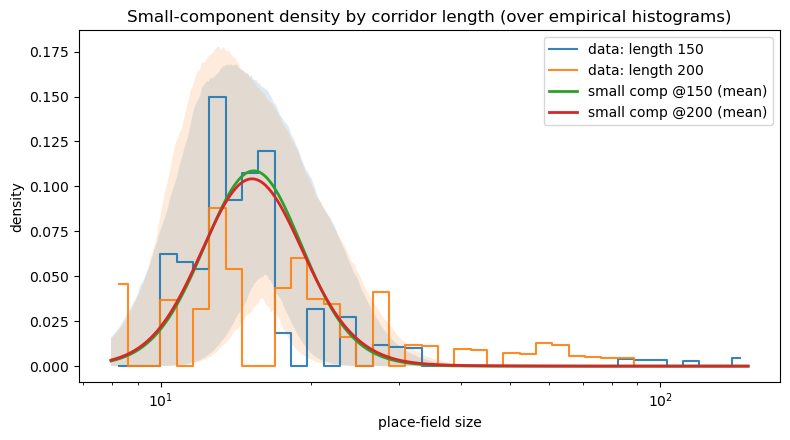

In [31]:
post = idata_mix_len.posterior
mu1_std_draw  = post["mu1_std"].values.reshape(-1)
sigma1_std_draw = post["sigma1_std"].values.reshape(-1)
gamma1_draw   = post["gamma1"].values.reshape(-1)

# transform to original log units for each condition
mu1_150 = ybar + ysd * (mu1_std_draw + 0*gamma1_draw)
mu1_200 = ybar + ysd * (mu1_std_draw + 1*gamma1_draw)
s1      = ysd * sigma1_std_draw

def lognorm_pdf(x, mu, sigma):
    return (1.0/(x*sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((np.log(x)-mu)/sigma)**2)

# grid and credible bands
x = np.logspace(np.log10(y_pos.min()), np.log10(y_pos.max()), 400)
rng = np.random.default_rng(0)
idx = rng.choice(len(mu1_150), size=min(1000, len(mu1_150)), replace=False)

F150 = np.vstack([lognorm_pdf(x, mu1_150[i], s1[i]) for i in idx])
F200 = np.vstack([lognorm_pdf(x, mu1_200[i], s1[i]) for i in idx])

f150_mean, f150_lo, f150_hi = F150.mean(0), np.quantile(F150, 0.05, 0), np.quantile(F150, 0.95, 0)
f200_mean, f200_lo, f200_hi = F200.mean(0), np.quantile(F200, 0.05, 0), np.quantile(F200, 0.95, 0)

# empirical histograms split by length
bins = np.logspace(np.log10(y_pos.min()), np.log10(y_pos.max()), 40)
h150, _ = np.histogram(y_pos[length==150], bins=bins, density=True)
h200, _ = np.histogram(y_pos[length==200], bins=bins, density=True)
centers = 0.5*(bins[:-1] + bins[1:])

fig, ax = plt.subplots(figsize=(8,4.5))
ax.set_xscale("log")

# data histograms
ax.step(centers, h150, where="mid", label="data: length 150", alpha=0.9)
ax.step(centers, h200, where="mid", label="data: length 200", alpha=0.9)

# small-component densities (posterior means + 90% bands)
ax.plot(x, f150_mean, label="small comp @150 (mean)", linewidth=2)
ax.fill_between(x, f150_lo, f150_hi, alpha=0.15)

ax.plot(x, f200_mean, label="small comp @200 (mean)", linewidth=2)
ax.fill_between(x, f200_lo, f200_hi, alpha=0.15)

ax.set_xlabel("place-field size")
ax.set_ylabel("density")
ax.set_title("Small-component density by corridor length (over empirical histograms)")
ax.legend()
plt.tight_layout(); plt.show()

Spatial selectivity and spatial information of individual cells

Category A (e.g. “blue family”)

#0072B2 – blue

#56B4E9 – sky blue

#009E73 – bluish green

Category B (warm family)

#D55E00 – vermilion

#E69F00 – orange

#CC79A7 – reddish purple

In [5]:
from pathlib import Path
import polars as pl

results_dir = Path("c:/Users/anneluka/Documents/Code/spatial-information/results")

files = [p for p in results_dir.glob("SI*.xlsx")]  # still matching by name

frames = [pl.read_csv(f).lazy() for f in files]    # <-- read_csv instead of read_excel
lf = pl.concat(frames, how="vertical")

# lf = lf.<do_stuff>

df = lf.collect()

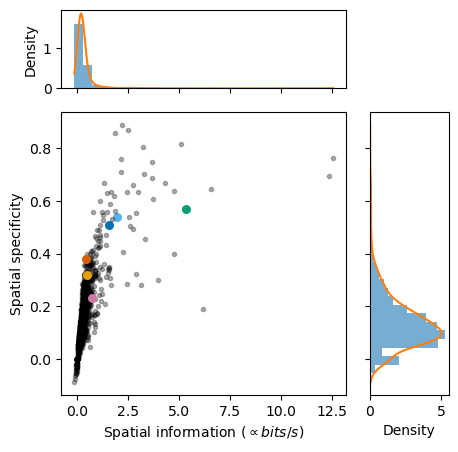

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

x = df["spatial information"].to_numpy()
y = df["spatial specificity"].to_numpy()

# --- KDE for both axes ---
kde_x = gaussian_kde(x)
kde_y = gaussian_kde(y)

# density curve ranges
x_eval = np.linspace(x.min(), x.max(), 300)
y_eval = np.linspace(y.min(), y.max(), 300)

# --- Figure layout ---
fig = plt.figure(figsize=(5,5))

# grid geometry: big scatter + top + right
grid = plt.GridSpec(4, 4, hspace=0.3, wspace=0.3)

ax_scatter = fig.add_subplot(grid[1:4, 0:3])

##0072B2 – blue

#56B4E9 – sky blue

#009E73 – bluish green


#D55E00 – vermilion

#E69F00 – orange

#CC79A7 – reddish purple

# point for neuron 2
highlight_x = 1.53
highlight_y = 0.51

# Center dot
ax_scatter.scatter(
    highlight_x,
    highlight_y,
    s=30,
    color="#0072B2",
    #zorder=10              # make sure it is on top
)

# point for neuron 15
highlight_x2 = 1.93
highlight_y2 = 0.54
# Center dot
ax_scatter.scatter(
    highlight_x2,
    highlight_y2,
    s=30,
    color="#56B4E9",
    #zorder=10              # make sure it is on top
)

# point for neuron 115
highlight_x3 = 5.31
highlight_y3 = 0.57
# Center dot
ax_scatter.scatter(
    highlight_x3,
    highlight_y3,
    s=30,
    color="#009E73",
    zorder=10              # make sure it is on top
)

# point for neuron 45
highlight_x4 = 0.44
highlight_y4 = 0.38
# Center dot
ax_scatter.scatter(
    highlight_x4,
    highlight_y4,
    s=30,
    color="#D55E00",
    zorder=10              # make sure it is on top
)

# point for neuron 210
highlight_x5 = 0.45
highlight_y5 = 0.32
# Center dot
ax_scatter.scatter(
    highlight_x5,
    highlight_y5,
    s=30,
    color="#E69F00",
    zorder=10              # make sure it is on top
)

# point for neuron 197
highlight_x6 = 0.72
highlight_y6 = 0.23
# Center dot
ax_scatter.scatter(
    highlight_x6,
    highlight_y6,
    s=30,
    color="#CC79A7",
    zorder=10              # make sure it is on top
)


ax_hist_x = fig.add_subplot(grid[0, 0:3], sharex=ax_scatter)
ax_hist_y = fig.add_subplot(grid[1:4, 3], sharey=ax_scatter)

# --- Scatter plot ---
ax_scatter.plot(x, y, '.', alpha=0.3, c="k")
ax_scatter.set_xlabel("Spatial information ($\propto bits/s$)")
ax_scatter.set_ylabel("Spatial specificity")

# --- Top histogram + KDE ---
ax_hist_x.hist(x, bins=30, alpha=0.6, density=True)
ax_hist_x.plot(x_eval, kde_x(x_eval))
ax_hist_x.set_ylabel("Density")
ax_hist_x.tick_params(axis="x", labelbottom=False)

# --- Right histogram + KDE ---
ax_hist_y.hist(y, bins=30, orientation="horizontal", alpha=0.6, density=True)
ax_hist_y.plot(kde_y(y_eval), y_eval)
ax_hist_y.set_xlabel("Density")
ax_hist_y.tick_params(axis="y", labelleft=False)

#plt.savefig("../results/spatial_spec_inf_scatter.svg")

plt.show()


In [10]:
df.select(df["spatial specificity"] > 0.2).sum()/len(df)


spatial specificity
f64
0.22028
